# UserBasicClassifier
Un classificador básico con la matadata del usuario

In [93]:
import pandas as pd
import numpy as np

import os
import pickle

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model  import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [94]:
users = pd.read_pickle('trainDatasets/users_dataset.pkl')

In [95]:
users = users[(users.user_type=='Human') | (users.user_type=='Spambot_2')]
users.head()

,id,screen_name,complete_name,description,verified,crawled_at,location,url,created_at,tweet_count,listed_count,favs_count,followers_count,following_count,bot,user_type
2372241176,2372241176,DennaMcsparren,Denna Mcsparren,NaN,NaN,2014-05-05 00:20:03,NaN,NaN,Tue Mar 04 18:11:08 +0000 2014,53,0,0,10,46,True,Spambot_2
2368684734,2368684734,YukikoTretter,Yukiko Tretter,NaN,NaN,2014-05-05 00:20:47,NaN,NaN,Sun Mar 02 10:38:13 +0000 2014,68,0,0,4,40,True,Spambot_2
2353855646,2353855646,RochelAmaro,Rochel Amaro,NaN,NaN,2014-05-05 00:20:03,NaN,NaN,Thu Feb 20 22:28:03 +0000 2014,79,0,0,9,39,True,Spambot_2
2372322542,2372322542,BrandiBabin,Brandi Babin,NaN,NaN,2014-05-05 00:20:03,NaN,NaN,Tue Mar 04 19:52:10 +0000 2014,59,0,0,1,39,True,Spambot_2
2352506778,2352506778,ChungPosadas,Chung Posadas,NaN,NaN,2014-05-05 00:20:03,NaN,NaN,Thu Feb 20 01:34:19 +0000 2014,73,0,0,7,36,True,Spambot_2


In [2]:
def transform_x(df):
    df.loc[:, 'crawled_at'] = pd.DatetimeIndex(pd.to_datetime(df.crawled_at, utc=None)).tz_convert(tz='UTC')
    df.loc[:, 'created_at'] = pd.DatetimeIndex(pd.to_datetime(df.created_at, utc=None)).tz_convert(tz='UTC')
    account_life = df.crawled_at - df.created_at
    account_life_meses = np.round(account_life.dt.days / 30)
    account_life_meses = account_life_meses.replace(0, 1)
    account_life_semanas = np.round(account_life.dt.days / 7)
    account_life_semanas = account_life_semanas.replace(0, 1)
    numValues = ['tweet_count', 'listed_count', 'followers_count', 'following_count']
    for i in numValues:
        colName_mes = i+'_mes'
        df.loc[:,colName_mes] = df[i] / account_life_meses

        colName_semana = i+'_semana'
        df.loc[:,colName_semana] = df[i] / account_life_semanas

    df.loc[:,'verified'] = ~df.verified.isna()
    df.loc[:,'description'] = ~df.description.isna()
    df.loc[:,'location'] = ~df.location.isna()
    df.loc[:,'url'] = ~df.url.isna()

    columnas = np.concatenate(
        [[x+'_mes', x+'_semana'] for x in numValues]
    )
    columnas = np.concatenate([
        [
            'verified',
            'description',
            'location',
            'url',
        ],
        columnas
    ])
    df = df[columnas]
    df = df.fillna(0)
    return df
    
#     def fit(self, x, y=0):
#         return self
#     def transform(self, x, y=0):
#         x = self.getVars(x)
#         return x
#     def fit_transform(self, x, y=0):
#         x = self.getVars(x)
#         return x

In [103]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('cat', CatBoostClassifier())
])

le = preprocessing.LabelEncoder()
x = transform_x(users)
y =  le.fit_transform(users['bot'])

X_train, X_test, y_train, y_test = train_test_split(x, y)

# pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('cat', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

El valor del AUC es:  0.9803062728365417


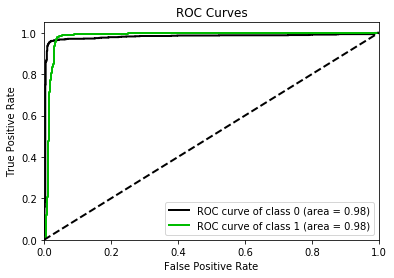

In [104]:
y_predicted_cat = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import roc_auc_score
cat_auc = roc_auc_score(y_test,y_predicted_cat[:,1])
print("El valor del AUC es: ", cat_auc)
from scikitplot.metrics import plot_roc
%matplotlib inline
plot_roc(y_test,y_predicted_cat, plot_micro = False, plot_macro= False)

In [105]:
# Matriz de Confusión
conf = confusion_matrix(y_test, y_pred)
predicted_cols = ['pred_'+str(c) for c in le.classes_]
display(pd.DataFrame(conf, index= ['real_Human','real_Bot'],columns = ['pred_Human','pred_Bot']))
print(classification_report(y_test, y_pred))

,pred_Human,pred_Bot
real_Human,709,177
real_Bot,4,843


             precision    recall  f1-score   support

          0       0.99      0.80      0.89       886
          1       0.83      1.00      0.90       847

avg / total       0.91      0.90      0.89      1733



In [106]:
# Re-Entrenar con el dataset completo
modelo = pipeline.fit(transform_x(users), y)

In [107]:
# # Exportar Modelo a archivo binario
filename = 'modelPipeline.pkl'
with open(filename, 'wb') as twModel:
    pickle.dump(modelo, twModel)

In [108]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=X_train.columns,
    class_names=le.classes_, 
    discretize_continuous=False
)

# X_train, X_test, y_train, y_test

In [109]:
i = np.random.randint(0, X_test.shape[0])

i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test.iloc[i], modelo.predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)